# Aqua Update Demos: Chemistry Applications

_Dimitar Trenev, Donny Greenberg, 13-Mar-20_

In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from chemistry.code.molecule import Molecule
from chemistry.code import MGSE
# Qiskit components
from qiskit.aqua.components.variational_forms import RY
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE
from qiskit import BasicAer
# TODO: ENABLE WHEN AQGD GETS UPDATED IN NEXT RELEASE:
#from qiskit.aqua.components.optimizers import AQGD
from chemistry.aqgd_epoch import AQGD_EPOCH as AQGD
from chemistry.qcalc_functions import get_quantum_instance

import chemistry.code.constants as const

In [2]:
"""
Build molecule and ansatz, run VQE, get energy, potential,
partition function, then thermo
"""

m = Molecule(geometry=[['H', [0., 0., 1.]],
                       ['H', [0., 0.45, 1.]],
                       ],
             masses=[1.6735328E-27, 1.6735328E-27],
             spins=[1 / 2, 1 / 2],
             degrees_of_freedom=[partial(Molecule.absolute_distance, atom_pair=(1, 0))],
             tapering=True)

In [3]:
# Analytic Quantum Gradient Descent (AQGD) (with Epochs)
aqgd_max_iter = [10] + [1] * 100
aqgd_eta = [1e0] + [1.0 / k for k in range(1, 101)]
aqgd_momentum = [0.5] + [0.5] * 100
optimizer = AQGD(maxiter=aqgd_max_iter, eta=aqgd_eta, momentum=aqgd_momentum, tol=1e-3, averaging=4)

# Min Eigensolver: VQE
min_eigensolver = VQE(var_form=RY(m.num_qubits, depth=1, initial_state=HartreeFock(m)), 
                      optimizer=optimizer)

# BOPES sampler
bs = MGSE(molecule=m,
          min_eigensolver=min_eigensolver,
          backend=QuantumInstance(BasicAer.get_backend('statevector_simulator')))

points = np.linspace(0.45, 5, 20)
results = bs.run(points, reps=1)
results

1


,point,energy
0,0.450000,-0.995115
1,0.689474,-1.135369
2,0.928947,-1.115313
3,1.168421,-1.063773
4,1.407895,-1.013995
5,1.647368,-0.977430
6,1.886842,-0.955167
7,2.126316,-0.943290
8,2.365789,-0.937447
9,2.605263,-0.934935


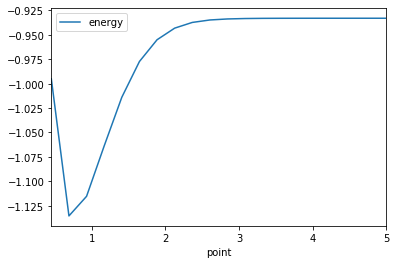

In [9]:
results.plot(x='point')

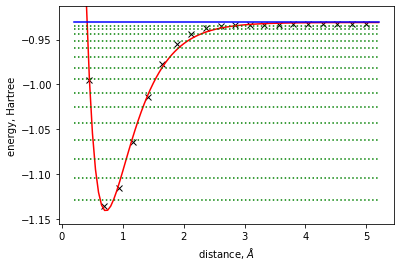

In [4]:
# Thermodynamic calculations follow.
# Note: They only depend on the result of the run and could just
#       as easily be intiated with 'results' read from the .csv file.

# 1. Fit a "full" energy surface using a (Morse) 1D potential.
from chemistry.code.morse_potential import MorsePotential
pes = MorsePotential(m)

#Note that the 1D potentials (Harmonic/Morse) have both
#   "energy surface" and "vibronic structure" functionality as
#   they inherit (and implement) both EnergySurfaceBase and
#   VibronicStructureBase classes, so (for illustrational purposes here)
#   we'll keep two separate references to the potential object.
energy_surface = pes
vibronic_structure = pes

xdata = results['point']
ydata = results['energy']
energy_surface.fitToData(xdata, ydata)

#1a. Plot the full (fitted) energy surface
plt.plot(xdata, ydata, 'kx')
x = np.arange(min(xdata) - 0.25, max(xdata) + 0.25, 0.05)
plt.plot(x, pes.eval(x), 'r-')
plt.xlabel(r'distance, $\AA$')
plt.ylabel('energy, Hartree')
dist = max(ydata) - min(ydata)
plt.ylim(min(ydata) - 0.1 * dist, max(ydata) + 0.1 * dist)

#1b. Plot the vibrational energy levels on the same figure.
for N in range(15):
    on = np.ones(x.shape)
    on *= (energy_surface.eval(energy_surface.getEquilibriumGeometry()) +
           vibronic_structure.vibrationalEnergyLevel(N))
    plt.plot(x, on, 'g:')
on = np.ones(x.shape)

#1c. Finally plot the dissociation limit of the system.
#    To that end we add the dissociation energy to the zero-point energy.
zeroPointEnergy = vibronic_structure.vibrationalEnergyLevel(0)
dissociationLimit = zeroPointEnergy + pes.dissociationEnergy()
on = np.ones(x.shape)
on *= (energy_surface.eval(energy_surface.getEquilibriumGeometry())
       +dissociationLimit)
plt.plot(x, on, 'b')

plt.show()

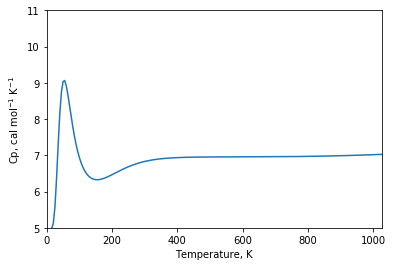

In [5]:
# 2. Create a partition function
from chemistry.code.partition_function import DiatomicPartitionFunction
Q = DiatomicPartitionFunction(m, pes)

P = 101350  # Pa
temps = np.arange(10, 1050, 5)  # K

# 2a. Calculate Cp heat capacity
# Here we illustrate the simplest usage of the partition function,
# namely creating a Thermodynamics object to compute properties like
# the constant pressure heat capacity
from chemistry.code.thermodynamics import Thermodynamics
td = Thermodynamics(Q)
td.setPressure(P)

ymin = 5
ymax = 11
plt.plot(temps,
         td.ConstantPressureHeatCapacity(temps) / const.CAL_TO_J)
plt.xlim(0, 1025)
plt.ylim(ymin, ymax)
plt.xlabel('Temperature, K')
plt.ylabel('Cp, cal mol$^{-1}$ K$^{-1}$')
plt.show()

In [6]:
# 2b. Here we demonstrate how to access particular components
#   (the rotational part) of the partition function, which in the
#   H2 case we can further split to para-hydrogen and ortho-hydrogen
#   components.
eq = Q.getPartition(part="rot", split="eq")
para = Q.getPartition(part="rot", split="para")
ortho = Q.getPartition(part="rot", split="ortho")

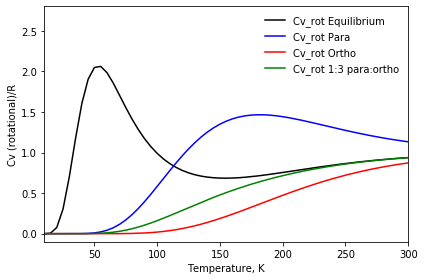

In [7]:
# 2c. We will now plot the constant volume heat capacity (of the
#   rotational part) demonstrating how we can call directly
#   the functions in the 'thermodynamics' module, providing a
#   callable object for the partition function (or in this case
#   its rotational component).
from chemistry.code.thermodynamics import ConstantVolumeHeatCapacity
HeatCapacity = ConstantVolumeHeatCapacity

# We will normalize the plot dividing by the universal gas
#   constant R (Avogadro's number times Boltzman's constant).
R = const.N_A * const.KB_J_PER_K
plt.plot(temps,
    HeatCapacity(eq, temps) / R, '-k',
         label='Cv_rot Equilibrium')
plt.plot(temps, HeatCapacity(para, temps) / R, '-b',
         label='Cv_rot Para')
plt.plot(temps, HeatCapacity(ortho, temps) / R, '-r',
         label='Cv_rot Ortho')
plt.plot(temps, 0.25 * HeatCapacity(para, temps) / R
                + 0.75 * HeatCapacity(ortho, temps) / R, '-g',
                label='Cv_rot 1:3 para:ortho')
plt.legend(loc='upper right', framealpha=100, frameon=False)
plt.xlim(10, 300)
plt.ylim(-0.1, 2.8)
plt.xlabel('Temperature, K')
plt.ylabel('Cv (rotational)/R')
plt.tight_layout()
plt.show()